In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
btc = pd.read_csv("coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv")

In [3]:
btc.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [4]:
btc['Date'] = pd.to_datetime(btc['Timestamp'], unit='s')

In [5]:
btc.count()[0]

1686594

In [6]:
idx = math.floor(0.80*btc.count()[0])
print(idx)

1349275


In [7]:
# msk = np.random.rand(len(btc)) < 0.8
# btc_train = btc[msk]
# btc_test = btc[~msk]

In [8]:
btc_train = btc[0:idx]

In [9]:
btc_test = btc[(idx+1):(btc.count()[0]-1)]

In [10]:
btc_test.iloc[btc_test.count()[0]-1]

Timestamp                     1522108740
Open                             8150.01
High                             8150.01
Low                              8122.82
Close                               8145
Volume_(BTC)                     68.2743
Volume_(Currency)                 555027
Weighted_Price                   8129.37
Date                 2018-03-26 23:59:00
Name: 1686592, dtype: object

In [11]:
btc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349275 entries, 0 to 1349274
Data columns (total 9 columns):
Timestamp            1349275 non-null int64
Open                 1349275 non-null float64
High                 1349275 non-null float64
Low                  1349275 non-null float64
Close                1349275 non-null float64
Volume_(BTC)         1349275 non-null float64
Volume_(Currency)    1349275 non-null float64
Weighted_Price       1349275 non-null float64
Date                 1349275 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 92.6 MB


In [12]:
btc_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337317 entries, 1349276 to 1686592
Data columns (total 9 columns):
Timestamp            337317 non-null int64
Open                 337317 non-null float64
High                 337317 non-null float64
Low                  337317 non-null float64
Close                337317 non-null float64
Volume_(BTC)         337317 non-null float64
Volume_(Currency)    337317 non-null float64
Weighted_Price       337317 non-null float64
Date                 337317 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 23.2 MB


Doing the resampling for each day

In [13]:
btc.index = btc.Date
btc = btc.resample('D').mean()

In [14]:
btc_train.index = btc_train.Date
btc_train = btc_train.resample('D').mean()

In [15]:
btc_test.index = btc_test.Date
btc_test = btc_test.resample('D').mean()

In [16]:
btc.dropna(axis = 0, how = 'all', inplace = True)
btc_test.dropna(axis = 0, how = 'all', inplace = True)
btc_train.dropna(axis = 0, how = 'all', inplace = True)

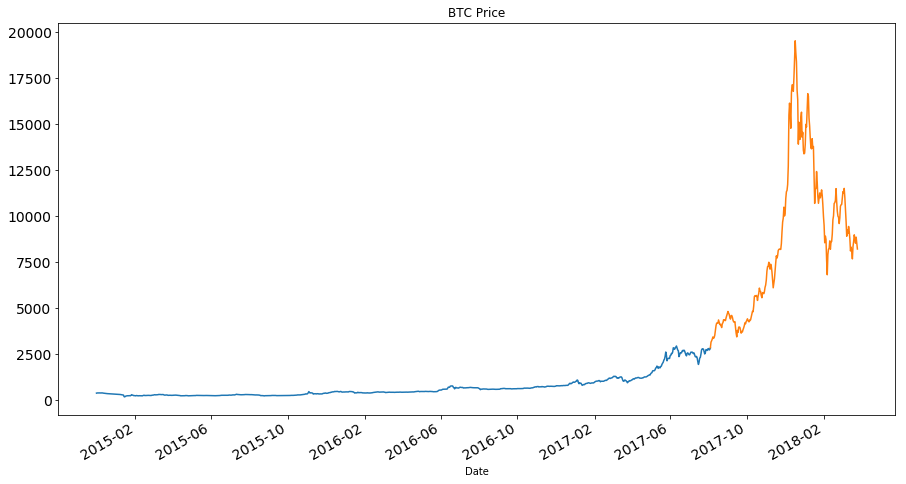

In [17]:
#Plotting data
btc_train.Close.plot(figsize=(15,8), title= 'BTC Price', fontsize=14)
btc_test.Close.plot(figsize=(15,8), title= 'BTC Price', fontsize=14)
plt.show()

# Naive Approach

if the graph shows a very constant type of trend of the form where y(t) = ~y(t-1). Then the next value can be forecasted by taking last value.

In [18]:
train_op = np.asarray(btc_train.Close)

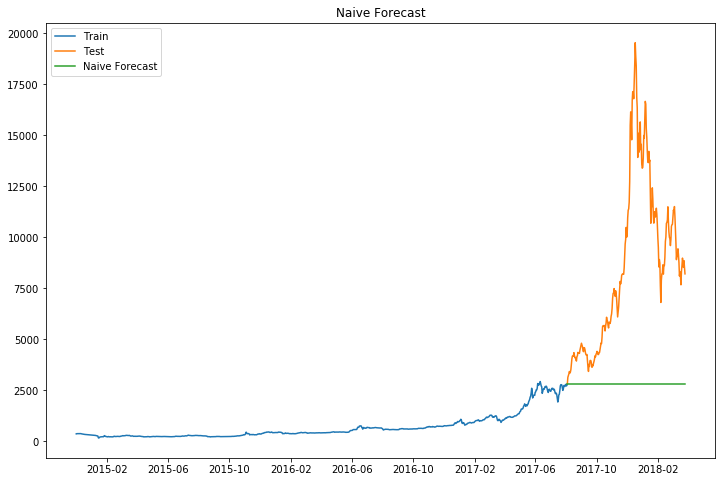

In [19]:
y_hat = btc_test.copy()
y_hat['naive'] = train_op[len(train_op)-1]
plt.figure(figsize=(12,8))
plt.plot(btc_train.index, btc_train['Close'], label='Train')
plt.plot(btc_test.index,btc_test['Close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(btc_test.Close, y_hat.naive))
print(rms)

7013.138762717042


# Average Method

If the graph varies slightly around the average then average can be predicted as the output.

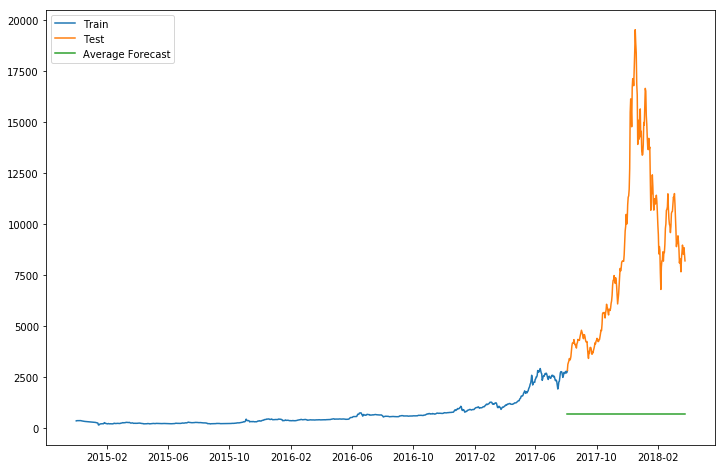

In [21]:
y_hat_avg = btc_test.copy()
y_hat_avg['avg_forecast'] = btc_train['Close'].mean()
plt.figure(figsize=(12,8))
plt.plot(btc_train['Close'], label='Train')
plt.plot(btc_test['Close'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [22]:
def calcRMSE(actual, forecast): 
    rms = sqrt(mean_squared_error(actual, forecast))
    print(rms)

In [23]:
calcRMSE(btc_test.Close, y_hat_avg['avg_forecast'])

8822.525971485416


The RMS scores for Naive and Average method are really bad. So time to try the next methodologies.

# Moving Average

Instead of taking the average of all previous occurences, we take average over a certain period of time that has had the most impact on the price. The time frame is called the sliding window.

y(i) = (1/p)(y(i-1)+y(i-2)+.....+y(i-p))

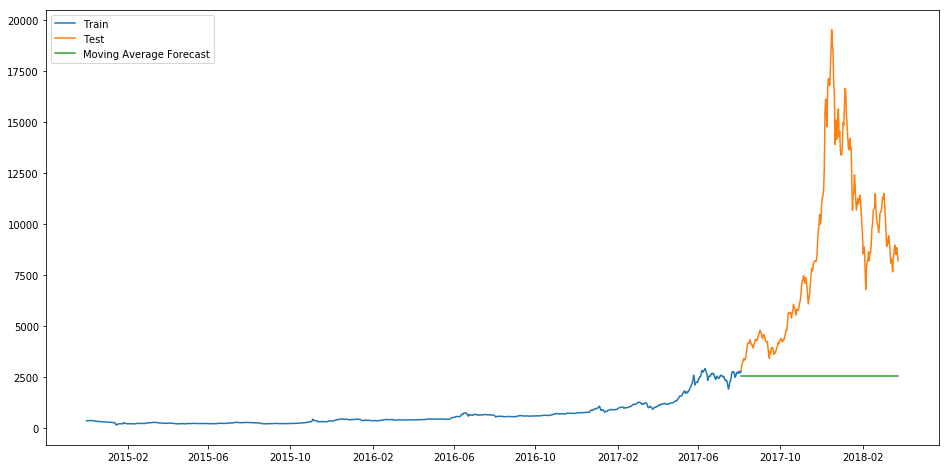

In [24]:
y_hat_avg = btc_test.copy()
y_hat_avg['moving_avg_forecast'] = btc_train['Close'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(btc_train['Close'], label='Train')
plt.plot(btc_test['Close'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [25]:
calcRMSE(btc_test['Close'],y_hat_avg['moving_avg_forecast'])

7212.954716920453


# ARIMA Methodology

Now applying the auto-regression integrated moving average methodology on the series to forecast the future outocmes of the time series.

In [26]:
from statsmodels.tsa.arima_model import ARIMA

In [27]:
history = [x for x in btc_train['Close']]
predictions = list()
for t in range(len(btc_test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = btc_test.iloc[t,4]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=2823.606747, expected=2841.085630
predicted=2839.726662, expected=3141.936465
predicted=3260.375902, expected=3215.720146
predicted=3162.960375, expected=3305.815014
predicted=3368.147566, expected=3421.965083
predicted=3431.894047, expected=3345.244917
predicted=3298.458026, expected=3394.508979
predicted=3442.696464, expected=3516.784639
predicted=3523.166051, expected=3791.130042
predicted=3884.021336, expected=4041.597514
predicted=4098.456350, expected=4177.751347
predicted=4225.874846, expected=4178.345264
predicted=4174.255839, expected=4172.110771
predicted=4179.933232, expected=4347.916514
predicted=4425.860017, expected=4231.416021
predicted=4157.331258, expected=4099.386639
predicted=4111.226735, expected=4106.936618
predicted=4101.447077, expected=4029.906306
predicted=3991.573401, expected=3934.906174
predicted=3929.120105, expected=4151.152375
predicted=4238.208627, expected=4197.773674
predicted=4159.465286, expected=4359.784646
predicted=4466.245834, expected=

predicted=8952.872266, expected=8736.636181
predicted=8812.180387, expected=7613.970403
predicted=7270.504565, expected=6807.273597
predicted=6676.757037, expected=7905.416028
predicted=8187.436377, expected=8203.784236
predicted=8232.719384, expected=8243.715354
predicted=8099.970218, expected=8649.373326
predicted=8880.873607, expected=8195.261715
predicted=8105.141448, expected=8619.035438
predicted=8650.279853, expected=8615.998597
predicted=8712.990135, expected=9019.139417
predicted=8999.495986, expected=9798.362437
predicted=10013.344992, expected=10017.390674
predicted=10039.536115, expected=10684.652396
predicted=10796.790233, expected=10729.090354
predicted=10814.250016, expected=10852.905000
predicted=10834.228605, expected=11493.998937
predicted=11682.810047, expected=10780.311528
predicted=10669.703554, expected=10267.798903
predicted=10121.145820, expected=9999.474299
predicted=10049.458832, expected=9932.505222
predicted=9887.614031, expected=9593.621931
predicted=9524.8

Test RMSE: 570.355


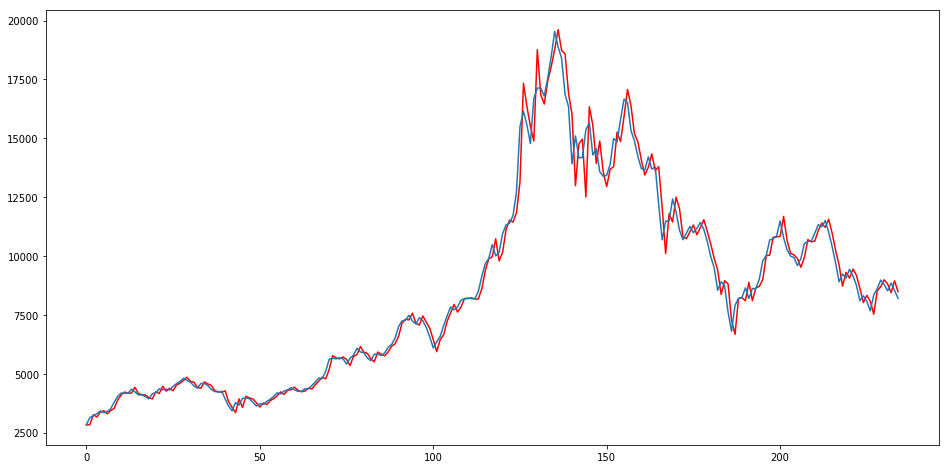

In [29]:
error = mean_squared_error(btc_test['Close'], predictions)
print('Test RMSE: %.3f' % math.sqrt(error))
# plot
plt.figure(figsize=(16,8))
plt.plot(predictions, color='red')
plt.plot(btc_test['Close'].tolist())
plt.show()